In [4]:
from src.algo import GeneralBooster
import time
import random
import string
import optuna
from contextlib import nullcontext
from typing import Any , Literal
class OptunaBooster(GeneralBooster):
    DEFAULT_SILENT_STUDY = False
    DEFAULT_N_TRIALS = 20
    DEFAULT_STORAGE = f'sqlite:///runs/optuna/booster_{time.strftime("%Y%m") }.sqlite3'

    @property
    def best_params(self):
        return self.study.best_trial.params
    
    def update_param(self , params : dict[str,Any] , **kwargs):
        super().update_param(params , **kwargs)
        self.n_trials = kwargs.get('n_trials' , self.DEFAULT_N_TRIALS)
        return self

    def trial_suggest_params(self, trial : optuna.Trial):
        if self.booster_type == 'lgbm':
            params = {
                'objective':        trial.suggest_categorical('objective', ['mse', 'mae']),  # 'mse', 'mae', 'softmax'
                'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'max_depth':        trial.suggest_int('max_depth', 3, 12),
                'num_leaves':       trial.suggest_int('num_leaves', 20, 100, step=10),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50, step=10),
                'reg_alpha':        trial.suggest_float('reg_alpha', 1e-7, 100, log=True),
                'reg_lambda':       trial.suggest_float('reg_lambda', 1e-6, 100, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0, step=0.1),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0, step=0.1),
            }
        elif self.booster_type == 'xgboost':
            params = {
                'objective':        trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror']), # 'reg:squarederror', 'reg:absoluteerror' , multi:softmax
                'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'max_depth':        trial.suggest_int('max_depth', 3, 12),
                'subsample':        trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
                'reg_alpha':        trial.suggest_float('reg_alpha', 1e-7, 100, log=True),
                'reg_lambda':       trial.suggest_float('reg_lambda', 1e-6, 100, log=True),
            }
        elif self.booster_type == 'catboost':
            params = {
                'objective':                trial.suggest_categorical('objective', ['RMSE', 'MAE']),
                'learning_rate':            trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'max_depth':                trial.suggest_int('max_depth', 3, 12),
                'l2_leaf_reg':              trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
                'bagging_temperature':      trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength':          trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
                'od_type':                  trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
                'min_data_in_leaf':         trial.suggest_int('min_data_in_leaf', 1, 100),
            }
        elif self.booster_type == 'ada':
            params = {
                'n_learner' :       trial.suggest_int('n_learner', 10 , 50 , step = 5), 
                'n_bins' :          trial.suggest_int('n_bins', 10, 30, step = 5) , 
                'max_nan_ratio' :   trial.suggest_float('max_nan_ratio', 0.5, 0.9, step = 0.1) ,
            }
        else: raise ValueError(f'Invalid booster type: {self.booster_type}')
        return params
    
    def fit(self , train = None , valid = None , use_feature = None , silent = False):
        self.import_data(train = train , valid = valid)
        self.booster.import_data(train=self.data['train'] , valid = self.data['valid'])
        self.booster.update_feature(use_feature)

        self.study_create()
        self.study_optimize(self.n_trials , silent = silent or self.DEFAULT_SILENT_STUDY)
        
        self.update_param(self.study.best_trial.params).booster.fit(silent=True)
        return self
    
    def study_create(self , direction='maximize'):
        name_str = self.given_name if self.given_name else self.booster.__class__.__name__
        time_str = time.strftime('%Y%m%d-%H%M%S') 
        rand_str =''.join(random.choices(string.ascii_letters + string.digits, k=10))
    
        self.study = optuna.create_study(storage=self.DEFAULT_STORAGE , direction = direction , study_name=f'{name_str}_{time_str}_{rand_str}')
        return self
    
    def study_objective(self , trial : optuna.Trial):
        params = self.trial_suggest_params(trial)
        booster = self.update_param(params).booster
        return booster.fit(silent=True).predict('valid').rankic().mean().item()
    
    class StudySilent:
        def __enter__(self):
            self.old_level = optuna.logging.get_verbosity()
            optuna.logging.set_verbosity(optuna.logging.WARNING)
        def __exit__(self , exc_type , exc_value , traceback):
            optuna.logging.set_verbosity(self.old_level)

    def study_optimize(self , n_trials : int = DEFAULT_N_TRIALS , silent = False):
        if self.booster_type in ['lgbm' , 'xgboost' , 'catboost']:
            max_trials = 100
        elif self.booster_type == 'ada':
            max_trials = 20
        else: 
            raise ValueError(f'Invalid booster type: {self.booster_type}')
        n_trials = min(max_trials , n_trials)

        with self.StudySilent() if silent else nullcontext():
            self.study.optimize(self.study_objective, n_trials = n_trials)
            
        return self

    def study_plot(self , plot_type : Literal['slice' , 'optimization_history' , 'param_importances' , 'contour'] , 
                   params : list[str] | None = None , **kwargs):
        if plot_type == 'slice':
            return optuna.visualization.plot_slice(self.study , params = params , **kwargs)
        elif plot_type == 'optimization_history':
            return optuna.visualization.plot_optimization_history(self.study , **kwargs)
        elif plot_type == 'param_importances':
            return optuna.visualization.plot_param_importances(self.study , **kwargs)
        elif plot_type == 'contour':
            return optuna.visualization.plot_contour(self.study , params = params , **kwargs)
        
    def param_importances(self):
        return optuna.importance.get_param_importances(self.study)


In [5]:
input_data = OptunaBooster.df_input()

In [6]:
booster = OptunaBooster('catboost' , n_trials=10)

booster.import_data(**input_data)
booster.fit(silent=False)

[I 2024-10-29 17:31:13,655] A new study created in RDB with name: CatBoost_20241029-173113_MnBU6wBKr9
[I 2024-10-29 17:31:24,231] Trial 0 finished with value: 0.11403515189886093 and parameters: {'objective': 'MAE', 'learning_rate': 0.00291991825635406, 'max_depth': 4, 'l2_leaf_reg': 0.08503583805128019, 'bagging_temperature': 0.5280769972659908, 'random_strength': 1.063873968395446e-06, 'od_type': 'IncToDec', 'min_data_in_leaf': 85}. Best is trial 0 with value: 0.11403515189886093.
[I 2024-10-29 17:31:35,043] Trial 1 finished with value: 0.1572216898202896 and parameters: {'objective': 'RMSE', 'learning_rate': 0.04147137441265551, 'max_depth': 6, 'l2_leaf_reg': 1.1796248305158843, 'bagging_temperature': 0.8140499561306895, 'random_strength': 0.0029964590560178574, 'od_type': 'IncToDec', 'min_data_in_leaf': 54}. Best is trial 1 with value: 0.1572216898202896.
[I 2024-10-29 17:33:18,289] Trial 2 finished with value: 0.1782383918762207 and parameters: {'objective': 'RMSE', 'learning_rate

In [3]:
import xgboost
ds = xgboost.DMatrix(**booster.booster.fit_train_ds.booster_inputs('xgboost' , group=booster.booster.booster_objective_rank))


In [7]:
ds.get_weight().size

23

In [11]:
arr = ds.get_weight()

In [13]:
(arr / arr).size

23

In [10]:
import torch
torch.ones(10).size()

torch.Size([10])

In [25]:
ds.get_weight().cumsum()[ds.get_group().cumsum() - 1]


array([  4171.,   8364.,  12587.,  16828.,  21082.,  25355.,  29637.,
        33906.,  38186.,  42482.,  46909.,  51370.,  55845.,  60338.,
        64846.,  69357.,  73877.,  78415.,  82969.,  87531.,  92095.,
        96673., 101270.], dtype=float32)

In [34]:
w = ds.get_weight()
[w[e-length:e].sum() for e , length in zip(ds.get_group().cumsum() , ds.get_group())]

[4171.0,
 4193.0,
 4223.0,
 4241.0,
 4254.0,
 4273.0,
 4282.0,
 4269.0,
 4280.0,
 4296.0,
 4427.0,
 4461.0,
 4475.0,
 4493.0,
 4508.0,
 4511.0,
 4520.0,
 4538.0,
 4554.0,
 4562.0,
 4564.0,
 4578.0,
 4597.0]

In [32]:
list(zip(ds.get_group().cumsum() , ds.get_group()))

[(4171, 4171),
 (8364, 4193),
 (12587, 4223),
 (16828, 4241),
 (21082, 4254),
 (25355, 4273),
 (29637, 4282),
 (33906, 4269),
 (38186, 4280),
 (42482, 4296),
 (46909, 4427),
 (51370, 4461),
 (55845, 4475),
 (60338, 4493),
 (64846, 4508),
 (69357, 4511),
 (73877, 4520),
 (78415, 4538),
 (82969, 4554),
 (87531, 4562),
 (92095, 4564),
 (96673, 4578),
 (101270, 4597)]

In [27]:
ds.get_group().cumsum() - 1

array([  4171,   8364,  12587,  16828,  21082,  25355,  29637,  33906,
        38186,  42482,  46909,  51370,  55845,  60338,  64846,  69357,
        73877,  78415,  82969,  87531,  92095,  96673, 101270],
      dtype=uint32)

In [24]:
ds.get_weight().size

101270

In [22]:
ds.get_group().cumsum()

array([  4171,   8364,  12587,  16828,  21082,  25355,  29637,  33906,
        38186,  42482,  46909,  51370,  55845,  60338,  64846,  69357,
        73877,  78415,  82969,  87531,  92095,  96673, 101270],
      dtype=uint32)

In [7]:
booster.best_params

{'objective': 'mse',
 'learning_rate': 0.0012563758558332416,
 'max_depth': 6,
 'num_leaves': 50,
 'min_data_in_leaf': 20,
 'reg_alpha': 2.2024704490931652e-07,
 'reg_lambda': 48.26174068590397,
 'feature_fraction': 0.2,
 'bagging_fraction': 0.2}

In [11]:
pred = booster.predict('test').pred

(array([  3.,   1.,   1.,   0.,   4.,   1.,   0.,   2.,   2.,   2.,   1.,
          4.,   2.,   5.,   2.,   4.,   5.,   9.,   6.,   3.,   4.,   8.,
         11.,   1.,  11.,   9.,   7.,  15.,   7.,  13.,  17.,  15.,  10.,
         23.,  12.,  19.,  26.,  21.,  20.,  41.,  22.,  24.,  23.,  19.,
         32.,  32.,  25.,  45.,  32.,  35.,  40.,  35.,  35.,  34.,  39.,
         45.,  52.,  49.,  42.,  51.,  74.,  54.,  63.,  84.,  96., 101.,
        107., 116., 132., 153., 137., 149., 130., 171., 162., 129., 139.,
        139., 142., 124.,  95.,  92.,  81.,  83.,  68.,  78.,  75.,  89.,
         86.,  96.,  82., 109., 136., 132., 132., 128., 128.,  89.,  40.,
         14.]),
 array([-1.42356084e-05,  5.94133155e-05,  1.33062239e-04,  2.06711163e-04,
         2.80360087e-04,  3.54009011e-04,  4.27657935e-04,  5.01306859e-04,
         5.74955783e-04,  6.48604707e-04,  7.22253630e-04,  7.95902554e-04,
         8.69551478e-04,  9.43200402e-04,  1.01684933e-03,  1.09049825e-03,
         1.164

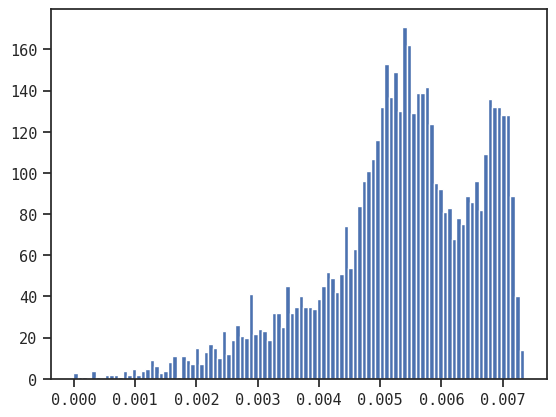

In [19]:
import matplotlib.pyplot as plt
plt.hist(pred , bins = 100)


In [12]:
booster.booster.data

{'train': secid=[     1      2      4 ... 872925 873169 873223]
 date=[20211029 20211130 20211231 20220128 20220228 20220331 20220429 20220531
  20220630 20220729 20220831 20220930 20221031 20221130 20221230 20230131
  20230228 20230331 20230428 20230531 20230630 20230731 20230831]
 feature=['Amount_20D_Avg', 'Amount_240D_Avg', 'Asset_LR', 'Asset_LR_Gr', 'Asset_LR_Ln', 'Bias_20D', 'Bias_5D', 'Bias_60D', 'BP_LR', 'BP_LR_Tangible', 'BuyMinusSell_5D_Amount', 'BuyMinusSell_5D_Vol', 'Capex2Revenue', 'CFROA_TTM', 'CFROE_TTM', 'CL', 'Close2MaxClose_240D', 'CloseTrend_240D_Reg', 'Close_Ln', 'CurAsset_LR_Gr', 'CurDebt_LR_Gr', 'CurrentRatio_LR', 'DayReturn_5D_Reg', 'Debt_LR_Gr', 'DP_LTM', 'EBIT2EV', 'EBITDA2EV', 'EPS_Fwd12M_R1M', 'EPS_Fwd12M_R3M', 'EPS_FY0_CV', 'EPS_FY0_R1M', 'EPS_FY0_R3M', 'EP_Fwd12M', 'EP_FY0', 'EP_FY1', 'EP_LYR', 'EP_LYR_Deducted', 'EP_TTM', 'EP_TTM_Deducted', 'Equity_LR_Gr', 'FCFP_LYR', 'FCFP_TTM', 'FixAsset_LR_Gr', 'FloatCap', 'FloatCap_Ln', 'FreeFloatCap_Ln', 'Free_FloatCa

In [21]:
pred = booster.predict('valid')
pred

BoosterOutput(pred=tensor([0.0051, 0.0051, 0.0057,  ..., 0.0042, 0.0069, 0.0069],
       dtype=torch.float64), secid=array([     1,      2,      4, ..., 872925, 873169, 873223]), date=array([20230928]), finite=tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]]), label=tensor([[-0.0661],
        [-0.1338],
        [ 0.0823],
        ...,
        [-0.1180],
        [-0.0675],
        [-0.0852]], dtype=torch.float64))

In [9]:
pred = booster.predict('train')

In [25]:
booster.study_plot('contour', params = ['objective' , 'max_depth'])

In [26]:
booster.study_plot('param_importances')

In [4]:
booster.study_plot('optimization_history')

In [5]:
booster.study_plot('slice')

In [12]:
booster.study_plot('contour', params = ['objective' , 'max_depth'])


In [ ]:
def objective(trial : optuna.Trial):

    params = {
        'metric':       trial.suggest_categorical('metric', [None,'rmse']) ,
        # 'seed':         trial.suggest_int('seed', 2023, 2023),  #随机种子固定，所以设置为2023-2023
        # 'num_boost_round':trial.suggest_int('num_boost_round', 50, 300),  #迭代器数量 50-300 的整数
        'learning_rate':trial.suggest_float('learning_rate', 1e-4, 0.1, log = True),
        'max_depth':    trial.suggest_int('max_depth', 3,10),  #整数    
        'linear_tree':  trial.suggest_categorical('linear_tree', [True,False]), 
        'lambda_l2':    trial.suggest_float('lambda_l2', 1e-6, 0.1, log = True),
        'alpha':        trial.suggest_float('alpha', 1e-7, 0.1, log = True),
    }

    model = booster.update_param(params)
    model = model.fit(silent=True)
    return model.predict('valid').rankic().mean().item()

study = optuna.create_study(storage='sqlite:///runs/optuna/optuna.sqlite3' , direction='maximize')
study.optimize(objective, n_trials=20)

print(study.best_params)

In [ ]:
study.best_params
study.best_trial.params

In [ ]:
model = booster.update_param(study.best_trial.params)
model = model.fit(silent=True)

In [ ]:
model.predict('test')

In [ ]:
study.best_params

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_contour(study, params=["learning_rate", "max_depth" ,'alpha'])

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
import optuna
 
# 需要优化的函数
def objective(trial : optuna.Trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2
 
# 使用study对象的optimize来优化，里面的参数是上面定义的方法，以及迭代次数
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), storage='sqlite:///db.sqlite3')
study.optimize(objective, n_trials=20)
 
print(study.best_params)
#{'x': 2.128194654190586}
